# Kalman filtering
This is an implementation as written in https://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf

* $k$: time label
* $x_k$: state vector, n x 1
* $w_k$: Wiener process in the system's evolution, n x 1
* $\Phi$: state transfer matrix $x_{k+1} = \Phi x_{k} + w_k$, n x n 
* $Q=E[w_k w_k^T]$: covariance matrix of the Wiener process of the evolution, n x n
* $\hat{x}_k$: estimate of state vector, n x 1
* $H$: Noiseless connection between state vector and measurement vector (m x n)
* $v_k$: Measurement error (m x 1)
* $R=E[v_k v_k^T]$: Covariance matrix of the measurement error
* $K_k$: Kalman gain (m x n)
* $P_k=E[e_k e_k^T]$: error covariance matrix, basically the error squared $e_k = x_k - \hat{x}_k$, n x n



In [1]:
import numpy as np
import matplotlib.pyplot as plt

def kalman_step(zk=np.array([[]]), xpk=np.array([[]]), Pk=np.array([[]]), Phi=np.array([[]]), Q=np.array([[]]), H=np.array([[]]), R=np.array([[]])):
    Kk = Pk @ H.transpose() @ np.linalg.inv(H @ Pk @ H.transpose() + R)
    xk = xpk + Kk @  (zk - H @ xpk)
    Pk = (np.eye(Pk.shape[0]) - Kk @ H) @ Pk
    xkp1 =  Phi @ xk
    Pkp1 = Phi @ Pk @ Phi.transpose() + Q

    return xk, xkp1, Pkp1, Kk

In [2]:
# Oscillator
dt = 0.01
Omega0 = 2*np.pi
Gamma = Omega0/1000
Omega = np.sqrt(Omega0**2 - (0.5*Gamma)**2)

lambdap = -Gamma/2+1j*Omega
lambdan = np.conjugate(lambdap)

# +++++++++++++++++++++++++++++++++
# THE MAGICAL CORRECTIONS
Gammaprime = -2*np.real(np.exp(lambdap*dt)-1)/dt 
Omegaprime = np.imag(np.exp(lambdap*dt)-1)/dt
# ++++++++++++++++++++++++++++++++++
Phi = np.array([[1-0.5*Gammaprime*dt, Omegaprime * dt], [-Omegaprime * dt, 1-0.5*Gammaprime * dt]])
Q = np.array([[0, 0], [0, np.sqrt(Gamma)*dt]])

x0 = np.array([0, 1.0])

# Real evolution:
N = 10000

t = dt * np.arange(N)
xs = np.zeros(shape=[N, 2])
xs[0] = x0[:]

xtheory = np.exp(-0.5 * Gamma * t) * np.cos(Omega*t)
ptheory = -np.exp(-0.5 * Gamma * t)*(0.5*Gamma*np.cos(Omega*t) + Omega *np.sin(Omega*t) )/Omega0 

for i in range(1, N):
    xs[i] = Phi @ xs[i-1] + np.random.multivariate_normal(np.zeros(2), Q)


# Now Kalman filter
P0 = np.zeros((2,2))

H = np.array([[1, 0], [0, 0]]) # Measurement of only the position quadrature
R = np.zeros((2,2))
R[0,0] = 1 # Uncertainty of position measurement
R[1,1] = 1e15 # Uncertaintiy of momentum measurement (I guess this should be infinite)
P0 = R[:] # I approximate the initial uncertainty matrix as the measurement uncertainty

xps = np.zeros(shape=(N, 2)) # Position estimates

Ps = np.zeros(shape=[N]+ list(P0.shape)) # Uncertainity matrices
Ps[0] = P0

zs = np.zeros(xs.shape) # Measurement values
zs[0] = H @ xs[0] + np.random.multivariate_normal(np.array([0, 0]), R)

xps[0] = zs[0] # First guess will be the first measurement
xps[0,1] = 0 # The first guessed momentum will be zero (the random number given by the high R[1,1] is too whack)

xfs = np.zeros(xs.shape) # Filtered values

Ks = np.zeros(shape=[N]+ list(P0.shape)) # Kalman gains


for i in range(N-1):
    zs[i] = H @ xs[i] + np.random.multivariate_normal(np.array([0, 0]), R) # Measure
    xfs[i], xps[i+1], Ps[i+1], Ks[i] = kalman_step(np.copy(zs[i]), np.copy(xps[i]), np.copy(Ps[i]), Phi, Q, H, R) # Estimate

zs[-1] = H @ xs[-1] + np.random.multivariate_normal(np.array([0, 0]), R) # Last measurement 
xfs[-1], _, _, Ks[i] = kalman_step(np.copy(zs[-1]), np.copy(xps[-1]), np.copy(Ps[-1]), Phi, Q, H, R) # Estimate


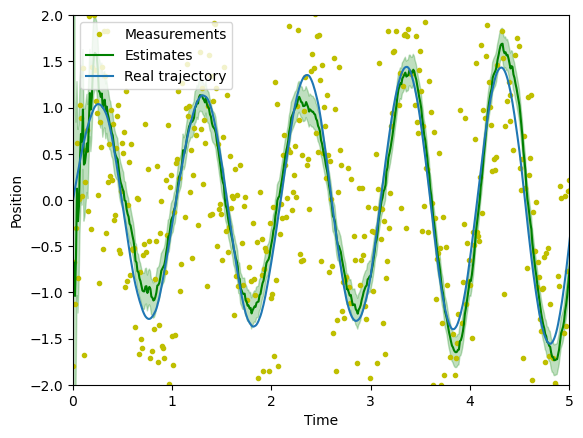

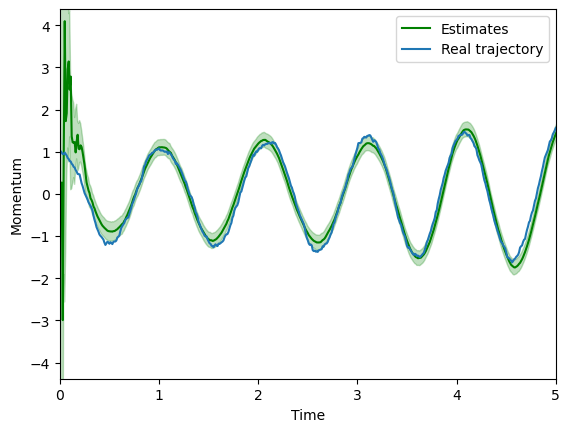

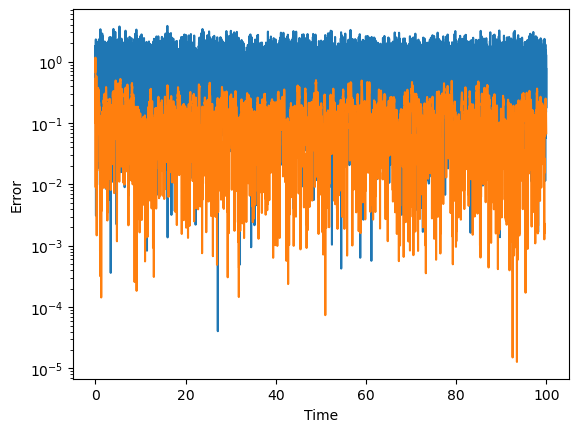

In [3]:

plt.plot(t, zs[:,0], ".", c="y", label="Measurements")
plt.plot(t, xfs[:,0], ms=0.25, label="Estimates", color="g")
plt.fill_between(t, xfs[:,0]-np.sqrt(Ps[:,0,0]), xfs[:,0]+np.sqrt(Ps[:,0,0]), color="g", alpha=0.25)
plt.plot(t, xs[:,0], label="Real trajectory")

#plt.ylim(np.min(xs[:,0]), np.max(xs[:,0]))
plt.legend()
plt.xlabel("Time")
plt.ylabel("Position")
plt.ylim(-2, 2)
plt.xlim(0, 5)
plt.show()

plt.plot(t, xps[:,1], label="Estimates", color="g")
plt.fill_between(t, xfs[:,1]-np.sqrt(Ps[:,1,1]), xfs[:,1]+np.sqrt(Ps[:,1,1]), color="g", alpha=0.25)
plt.plot(t, xs[:,1], label="Real trajectory")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Momentum")
plt.ylim(-1.2 * np.max(xfs[N//10:,1]), 1.2* np.max(xfs[N//10:,1]))
plt.xlim(0, 5)
plt.show()

plt.plot(t, np.abs(xs[:,0] - zs[:,0]))
plt.plot(t, np.abs(xs[:,0] - xfs[:,0]))
plt.xlabel("Time")
plt.ylabel("Error")
plt.yscale("log")

plt.show()

* What is the steady state of the Kalman filter?
* Maybe it is when the the the Kalman gain reaches a steady state?
* This is equivalent to the covariance matrix reaching a steady state


Text(0, 0.5, 'P[0,0]')

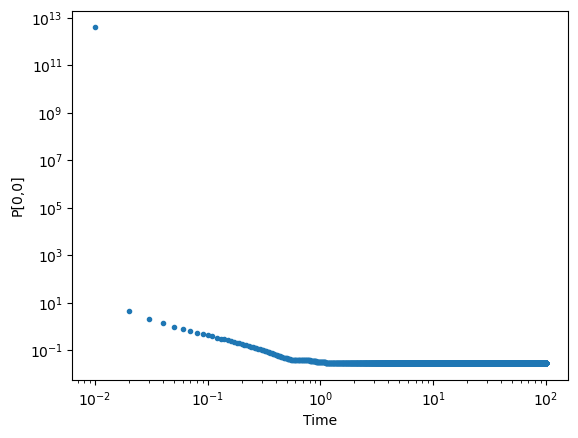

In [4]:
plt.plot(t, Ps[:, 0, 0], ".")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Time")
plt.ylabel("P[0,0]")

Text(0, 0.5, 'K[0,0]')

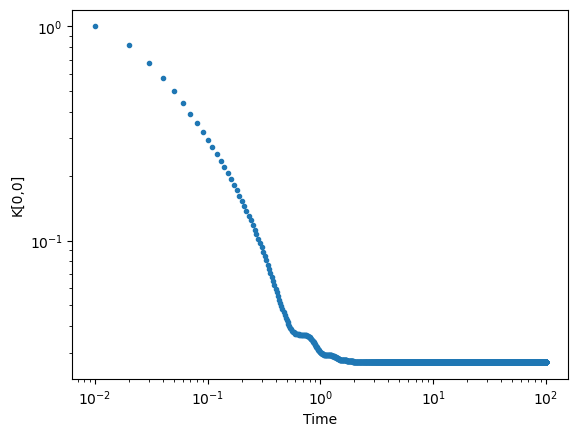

In [5]:
plt.plot(t, Ks[:, 0, 0], ".")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Time")
plt.ylabel("K[0,0]")


If we look at the equations for the Kalman filter, we can try to derive the condition for $P_{k+1} = P_k$ is. Given the previous estimate for $P_k$ that we name $P_k^\prime$, we determine $P_k$ through:
$$
P_k = (I - K_k H)P_k^\prime
$$  
The Kalman gain $K_k$ is a function of $P_k^\prime$ alone, therefore:
$$
P_k = (I - P_k^{\prime} H^T\left(H P_k^{\prime} H^T+R\right)^{-1} H)P_k^\prime
$$ 
Armed with the estimate for $P$ in our current step, we can project our estimate prediction for $P_{k+1}$ , which we label $P_{k+1}^\prime$
$$
P_{k+1}^\prime = \Phi P_k \Phi ^t + Q = \Phi ((I - P_k^{\prime} H^T\left(H P_k^{\prime} H^T+R\right)^{-1} H)P_k^\prime) \Phi ^t + Q
$$
Now, in the steady state $P^{ss}$, our estimate of $P$ for the next time-step is going to be equal to the estimate for $P$ that we were given by the previous time step, so $P_{k+1}^\prime = P_{k}^\prime$:
$$
P^{ss} = \Phi P^{ss} \Phi ^t - \Phi P^{ss} H^T\left(H P^{ss} H^T+R\right)^{-1} H P^{ss} \Phi ^t + Q
$$
This is the discrete time Ricatti equation seting $A=\Phi^t, B=H^t, R=R, Q=Q$. I'll solve it numerically below:

In [6]:
from control import dare

X, L, G = dare(Phi.transpose(), H.transpose(), Q, R) 

In [7]:
np.allclose(X, Ps[-1])

True

Cool, the steady state filter can be found using the parameters of the system.


Let's see how it compares (using the same data) to the real Kalman filter:

In [8]:
xSSfs = np.zeros(shape=(N, 2)) # Position estimates


xSSfs[0] = zs[0] # First guess will be the first measurement
xSSfs[0,1] = 0 # The first guessed momentum will be zero (the random number given by the high R[1,1] is too whack)

KSS = Ks[-2]
PSS = Ps[-2]

for i in range(N-1):
    xSSfs[i+1] = Phi @ (xSSfs[i] + KSS @  (zs[i] - H @ xSSfs[i]))

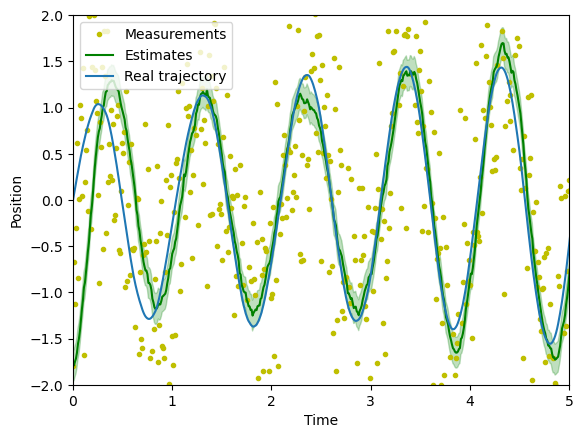

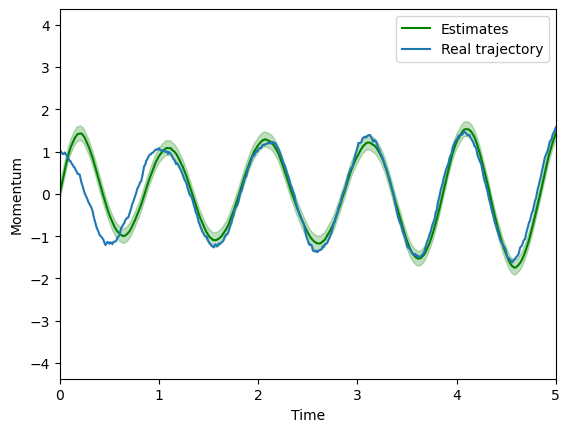

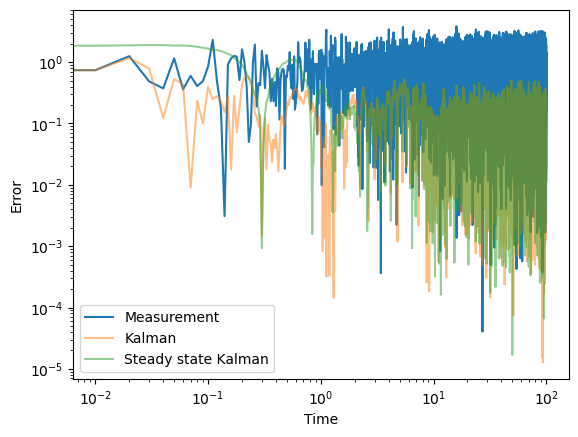

In [9]:
plt.plot(t, zs[:,0], ".", c="y", label="Measurements")
plt.plot(t, xSSfs[:,0], ms=0.25, label="Estimates", color="g")
plt.fill_between(t, xSSfs[:,0]-np.sqrt(PSS[0,0]), xSSfs[:,0]+np.sqrt(PSS[0,0]), color="g", alpha=0.25)
plt.plot(t, xs[:,0], label="Real trajectory")

#plt.ylim(np.min(xs[:,0]), np.max(xs[:,0]))
plt.legend()
plt.xlabel("Time")
plt.ylabel("Position")
plt.ylim(-2, 2)
plt.xlim(0, 5)
plt.show()

plt.plot(t, xSSfs[:,1], label="Estimates", color="g")
plt.fill_between(t, xSSfs[:,1]-np.sqrt(PSS[1,1]), xSSfs[:,1]+np.sqrt(PSS[1,1]), color="g", alpha=0.25)
plt.plot(t, xs[:,1], label="Real trajectory")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Momentum")
plt.ylim(-1.2 * np.max(xSSfs[N//10:,1]), 1.2* np.max(xSSfs[N//10:,1]))
plt.xlim(0, 5)
plt.show()

plt.plot(t, np.abs(xs[:,0] - zs[:,0]), label="Measurement")
plt.plot(t, np.abs(xs[:,0] - xfs[:,0]), alpha=0.5, label="Kalman")
plt.plot(t, np.abs(xs[:,0] - xSSfs[:,0]), alpha=0.5, label="Steady state Kalman")
plt.xlabel("Time")
plt.ylabel("Error")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()


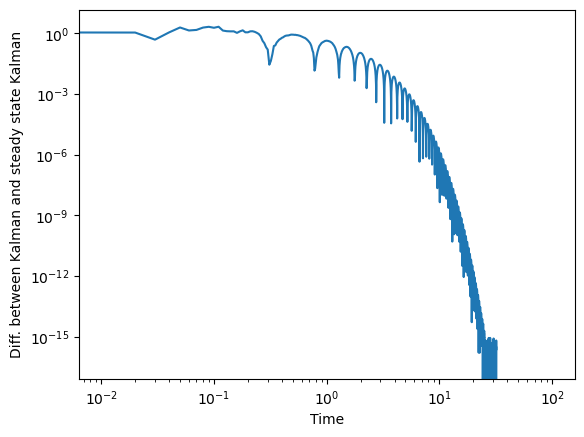

In [10]:

plt.plot(t, np.abs(xSSfs[:,0]-xps[:,0]))
plt.ylabel("Diff. between Kalman and steady state Kalman")
plt.xlabel("Time")
plt.yscale("log")
plt.xscale("log")
plt.show()